In [ ]:
"""
UNIVERSITY OF ARIZONA
Author: Lavanya Umapathy
Date: 
Description: Demo Script to predict thalamic nuclei on MPRAGE images
Two different Convolutional Neural Network based schemes are used for thalamic parcellation.
a) Native Contrast Segmentation: A segmentation CNN directly predicts the thalamus and 12 thalamic nuclei on 
    MPRAGE images.
b) Synthesized Contrast Segmentation: A contrast synthesis CNN first generates a white matter nulled representation 
    of MPRAGE images. This is followed by a segmentation CNN.
Segmentation CNNs were trained using ground truth labels from a multi atlas based thalamic nuclei parcellation 
algorithm (THOMAS) (Su et al. 2019 )
More details are available in:
L Umapathy, MB Keerthivasan, N Zahr, A Bilgin, and M Saranathan ” A Contrast Synthesized Thalamic Nuclei Segmentation Scheme 
using Convolutional Neural Networks.Under revision. Neuroinformatics. 2021
If you use this CNN model in your work, please site the work above.
"""

In [2]:
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
from ModelSetup import setTF_environment
from utils import loadMPRAGE_nii

Using TensorFlow backend.


In [3]:
'''
Enter path of a pre-processed nifti volume. The nifti volume is expected to be brain-extracted and/or bias-corrected
'''

loadPath = "./Data/"

t1_loadPath = os.path.join(loadPath, 't1.nii.gz')
t1_brainMaskPath = os.path.join(loadPath, 't1_brain_mask.nii.gz')
isotropic_resample = True # set this option if MPRAGE images are not 1mm isotropic
visible_gpu = '4,6'
setTF_environment(visible_gpu)

In [4]:

mprage_nii, brainMask_nii = loadMPRAGE_nii(t1_loadPath, t1_brainMaskPath, isotropic_resample)
mprage_nii = np.fliplr(np.rot90(mprage_nii))  # to ensure images in the volume are axially oriented
brainmask_nii = np.fliplr(np.rot90(brainMask_nii))

Loading pre-processed data
Contrast stretching...


(-0.5, 180.5, 210.5, -0.5)

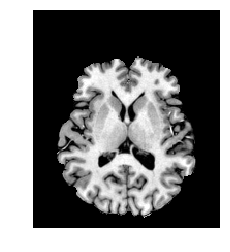

In [5]:
sliceIdx = 91
plt.imshow(mprage_nii[...,sliceIdx], cmap='gray')
plt.axis('off')

In [6]:
'''
instantiate native contrast segmentation framework for segmentation of thalamus and 12 thalamic nuclei.
Segmentation CNN is loaded with pretrained model weights
'''
from NativeContrastSegmentation import NCS

model_loadPath = "./Pretrained_models/GPUs/"
NCS_CNN = NCS(loadPath=model_loadPath, visible_gpu=visible_gpu)

Loading pretrained weights for segmentation...


In [7]:
# Predictions from left to right: left thalamus, left thalamic nuclei, right thalamus, right thalamic nuclei

T1_T_L, T1_N_L, T1_T_R, T1_N_R = NCS_CNN.predictThalamicNuclei(mprage_nii)


Thalamic Nuclei prediction for left side...
Thalamic Nuclei prediction for right side...
Post-processing and restoring image to original size...
Mapping labels based on THOMAS legend...


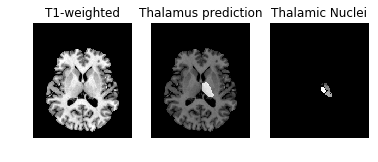

In [8]:
plt.subplot(1,3,1)
plt.imshow(mprage_nii[...,sliceIdx], cmap='gray')
plt.title('T1-weighted')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(mprage_nii[...,sliceIdx],cmap='gray')
plt.imshow(T1_T_L[...,sliceIdx], cmap='gray',alpha=0.5)
plt.title('Thalamus prediction')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(T1_N_L[...,sliceIdx], cmap='gray')
plt.title('Thalamic Nuclei')
plt.axis('off')
plt.show()

In [9]:
# Instantiate synthesized contrast segmentation framework

from SynthesizedContrastSegmentation import SCS

SCS_CNN = SCS(loadPath=model_loadPath, visible_gpu=visible_gpu)


Loading pretrained weights for segmentation...
K.image_dim_ordering: tf
Loading pretrained weights for synthesis...


In [12]:
'''Framework for segmenting thalamic nuclei on MPRAGE images by first transforming MPRAGE images to
a white matter nulled MPRAGE representation. White matter nulled MPRAGE representation has been shown
to improve thalamic nuclei conspicuity
'''

synth_wmn_mprage = SCS_CNN.predictSynthesizedRepresentation(mprage_nii, brainmask_nii)


Generating synthesized representation of MPRAGE
Sliding window predictions for synthesis...
Time Elapsed:  3.4116110801696777


(-0.5, 361.5, 210.5, -0.5)

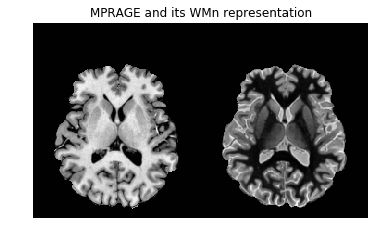

In [13]:
# Display MPRAGE image and its white matter nulled MPRAGE representation
slice_idx = 91
plt.imshow(np.hstack((mprage_nii[...,slice_idx], synth_wmn_mprage[...,slice_idx])), cmap='gray')
plt.title('MPRAGE and its WMn representation')
plt.axis('off')


In [14]:

'''
Predict thalamic nuclei using SCS framework
T_L: Binary mask for thalamus (left)
N_L: Binary mask for thalamic nuclei (left)
T_R: Binary mask for thalamus (right)
N_R: Binary mask for thalamic nuclei (right)
'''
T_L, N_L, T_R, N_R = SCS_CNN.predictThalamicNuclei(mprage_nii, brainmask_nii)

Generating synthesized representation of MPRAGE
Sliding window predictions for synthesis...
Time Elapsed:  3.575023889541626
Contrast stretching...
Thalamic Nuclei prediction for left side...
The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
Thalamic Nuclei prediction for right side...
Post-processing and restoring image to original size...
Mapping labels based on THOMAS legend...



THOMAS Label Legend:
0 Background  
2 AV   Anterior Ventral nucleus 
4 VA   Ventral anterior nucleus (VA)
5 VLa  Ventral lateral anterior nucleus 
6 VLP  Ventral lateral posterior nucleus 
7 VPL  Ventral posterior lateral nucleus
8 Pul  Pulvinar nucleus 
9 LGN  Lateral geniculate nucleus 
10 MGN Medial geniculate nucleus 
11 CM  Centromedian nucleus 
12 MD  Mediodorsal nucleus 
13 Hb  Habenular nucleus 
14 MTT Mammillothalamic tract 

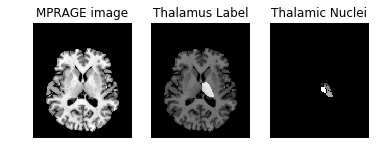

In [15]:

plt.subplot(1,3,1)
plt.imshow(mprage_nii[...,slice_idx], cmap='gray')
plt.title('MPRAGE image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(mprage_nii[...,slice_idx], cmap='gray')
plt.imshow(T_L[...,slice_idx], alpha=0.5,cmap='gray')
plt.title('Thalamus Label')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(N_L[...,slice_idx], cmap='gray')
plt.title('Thalamic Nuclei')
plt.axis('off')
plt.show()

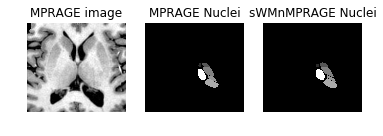

In [16]:
# Cropped Thalamus
plt.subplot(1,3,1)
plt.imshow(mprage_nii[70:160,40:140,slice_idx], cmap='gray')
plt.title('MPRAGE image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(T1_N_L[70:160,40:140,slice_idx], cmap='gray')
plt.title('MPRAGE Nuclei')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(N_L[70:160,40:140,slice_idx], cmap='gray')
plt.title('sWMnMPRAGE Nuclei')
plt.axis('off')
plt.show()